In [146]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import sys
import os

## Global parameters

In [147]:
signifive_p_thres = 10**(-5)
genome_wide_p_thres = 5 * (10**(-8))
#labels_folder = 'Tclin'
labels_folder = 'Tier1'

plt.rcParams.update({'font.size': 18})


## Top drugnomeAI hits

In [148]:
top_drugnome = pd.read_csv('gene-lists/'+labels_folder+'/top_genes.txt', header=None).iloc[:, 0]

top_drugnome_clin = pd.read_csv('gene-lists/'+labels_folder+'/top_genes_with_clinical_evidence.txt', header=None).iloc[:, 0]
top_drugnome_no_clin = pd.read_csv('gene-lists/'+labels_folder+'/top_genes_without_clinical_evidence.txt', header=None).iloc[:, 0]

In [149]:
top_drugnome_ranking = pd.read_csv('gene-lists/'+labels_folder+'/GradientBoostingClassifier.drugnome_ai_predictions.csv')

In [150]:
top_drugnome_ranking.head(4)

,Gene_Name,drugnome_ai_proba,drugnome_ai_perc,known_gene
0,HSD11B1,0.999312,100.000000,1.0
1,SLCO1B1,0.999227,99.994961,1.0
2,SLCO1B3,0.999225,99.989922,1.0
3,PTGS1,0.999206,99.984884,1.0


<br>
<hr>

## Read PheWAS results

In [151]:
phewas_dir = '/projects/cgr/users/cgr-ds/UKB-clone/Box-Results/UKB_450K_archives/csv'

#### PheWAS - binary

In [152]:
phewas_bin = pd.read_csv(phewas_dir + '/PheWAS_UKBv4_binary_p00001_20201223.csv', low_memory=False)

In [153]:
phewas_bin.columns

Index(['model', 'phenotype', 'chapter', 'genotype', 'CaseQ', 'CaseNQ',
       'Case Freq', 'CtrlQ', 'CtrlNQ', 'Ctrl Freq', 'pValue', 'oddsRatio',
       'oddsLCI', 'oddsUCI', 'chr', 'OMIM', 'Druggability', 'PHRED',
       'Batch QC Caution'],
      dtype='object')

In [154]:
print(phewas_bin.shape)
phewas_bin.head(2)

(163675, 19)


,model,phenotype,chapter,genotype,CaseQ,CaseNQ,Case Freq,CtrlQ,CtrlNQ,Ctrl Freq,pValue,oddsRatio,oddsLCI,oddsUCI,chr,OMIM,Druggability,PHRED,Batch QC Caution
0,flexdmg,NASH3.smart_using baseline biochemistry result...,"Chapter IV Endocrine, nutritional and metaboli...",GPT,74.0,104735.0,0.071%,1733.0,176674.0,0.971%,1.430000e-248,0.072,0.0571,0.0909,8,NaN,Tbio,2478.440570,0.0
1,flexdmg,AZ_NASH3-AST_ALT_RATIO_lt1.0,Chapter XI Diseases of the digestive system,GPT,74.0,104735.0,0.07%,1711.0,176696.0,0.96%,1.520000e-244,0.073,0.0578,0.0921,8,.,Tbio,2438.181564,0.0


<br>

#### PheWAS - quantitative

In [155]:
phewas_quant = pd.read_csv(phewas_dir + '/PheWAS_UKBv4_quantitative_p0001_20201223.csv', low_memory=False)

In [156]:
phewas_quant = phewas_quant.rename(columns={'geno': 'genotype', 'p': 'pValue'})

In [157]:
phewas_quant.columns

Index(['genotype', 'pheno', 'Field', 'Root', 'nSamples', 'nCases', 'nControls',
       'pValue', 'beta', 'lower', 'upper', 'se', 'MedCases', 'MedControls',
       'model', 'chr', 'OMIM', 'Druggability', 'PHRED', 'Batch_QC_flag'],
      dtype='object')

In [158]:
phewas_quant.head(2)

,genotype,pheno,Field,Root,nSamples,nCases,nControls,pValue,beta,lower,upper,se,MedCases,MedControls,model,chr,OMIM,Druggability,PHRED,Batch_QC_flag
0,ALPL,30610,Alkaline phosphatase,Chapter XI Diseases of the digestive system,376618,3688,372930,0.0,-1.565146,-1.596487,-1.533806,0.015991,-1.771219,0.009939,flexdmg,1,Hypophosphatasia; adult; 146300 (3); Autosomal...,Tchem,3000.0,0
1,ALPL,30610,Alkaline phosphatase,Chapter XI Diseases of the digestive system,376618,2270,374348,0.0,-1.523452,-1.563534,-1.483370,0.020450,-1.824628,0.006032,flexnonsynmtr,1,Hypophosphatasia; adult; 146300 (3); Autosomal...,Tchem,3000.0,0


<br>
<hr>

## Read ExWAS results

#### ExWAS - Binary

In [159]:
exwas_bin = pd.read_csv(phewas_dir + '/ExWAS_UKBv4_binary_p00001_20201223.csv', low_memory=False)

In [160]:
exwas_bin.rename(columns={'genotype': 'variant_genotype', 'Gene Name': 'genotype'}, inplace=True)
exwas_bin.columns

Index(['model', 'phenotype', 'Chapter', 'variant_genotype', 'genotype',
       'Most Damaging Effect', 'C00', 'C01', 'C10', 'C11', 'pValue',
       'oddsRatio', 'oddsLCI', 'oddsUCI', 'CaseMAF', 'CtrlMAF', 'CaseGT',
       'CtrlGT', 'OMIM', 'Druggability', 'PHRED', 'Chr6 - MHC',
       'Batch_QC_flag', 'gene', 'alleles'],
      dtype='object')

In [161]:
exwas_bin.genotype = exwas_bin.genotype.str.replace("'", "")

In [162]:
exwas_bin.head(2)

,model,phenotype,Chapter,variant_genotype,genotype,Most Damaging Effect,C00,C01,C10,C11,...,CtrlMAF,CaseGT,CtrlGT,OMIM,Druggability,PHRED,Chr6 - MHC,Batch_QC_flag,gene,alleles
0,allelic,20002#1313#ankylosing spondylitis,Chapter XIII Diseases of the musculoskeletal s...,6-31411975-C-T,MICA,synonymous_variant,650.0,1568.0,21172.0,464366.0,...,0.0436,'483/602/24','222089/20188/492',NaN,Tbio,3000,Yes,0.0,MICA,21822.0
1,allelic,20002#1456#malabsorption|coeliac disease,Chapter XI Diseases of the digestive system,6-31111867-G-A,C6orf15,synonymous_variant,1471.0,1961.0,90960.0,509362.0,...,0.1515,'474/1013/229','216208/76946/7007',NaN,Tdark,3000,Yes,0.0,C6orf15,92431.0


#### ExWAS - Quantitative

In [163]:
exwas_quant = pd.read_csv(phewas_dir + '/ExWAS_UKBv4_quantitative_p00001_20201223.csv', low_memory=False)

In [164]:
exwas_quant.rename(columns={'genotype': 'variant_genotype', 'Gene Name': 'genotype', 'p': 'pValue'}, inplace=True)

In [165]:
exwas_quant.columns

Index(['model', 'geno', 'genotype', 'Most Damaging Effect', 'pheno', 'Field',
       'Path', 'Root', 'nSamples', 'nCases', 'nControls', 'pValue', 'beta',
       'lower', 'upper', 'se', 'MedCases', 'MedControls', 'chr'],
      dtype='object')

In [166]:
exwas_quant.head()

,model,geno,genotype,Most Damaging Effect,pheno,Field,Path,Root,nSamples,nCases,nControls,pValue,beta,lower,upper,se,MedCases,MedControls,chr
0,dominant,1-55039974-G-T,PCSK9,missense_variant,30640,Apolipoprotein B,Biological samples > Assay results > Blood ass...,Chapter IX Diseases of the circulatory system,374736,12981,361755,0.0,-0.351660,-0.369100,-0.334220,0.008898,-0.326856,0.020284,1
1,dominant,1-55039974-G-T,PCSK9,missense_variant,30780,LDL direct,Biological samples > Assay results > Blood ass...,Chapter IX Diseases of the circulatory system,375878,13031,362847,0.0,-0.354594,-0.371951,-0.337237,0.008856,-0.334594,0.024531,1
2,dominant,1-65623018-C-A,LEPR,non_coding_transcript_exon_variant,30710,C-reactive protein,Biological samples > Assay results > Blood ass...,Chapter III Diseases of the blood and blood-fo...,369454,220160,149294,0.0,-0.155985,-0.162459,-0.149510,0.003303,-0.066048,0.095302,1
3,dominant,1-65636574-G-A,LEPR,synonymous_variant,30710,C-reactive protein,Biological samples > Assay results > Blood ass...,Chapter III Diseases of the blood and blood-fo...,375496,226446,149050,0.0,-0.159760,-0.166202,-0.153318,0.003287,-0.067069,0.098376,1
4,dominant,1-158547352-C-T,OR6Y1,missense_variant,30260,Mean reticulocyte volume,Biological samples > Assay results > Blood ass...,Chapter III Diseases of the blood and blood-fo...,376232,155068,221164,0.0,0.146813,0.140412,0.153215,0.003266,0.083085,-0.067741,1


<br>
<br>
<br>
<hr>
<br>
<br>

# Main Analysis

In [167]:
def get_drugnomeai_phewas_enrichment(drugnome_hits, drugnome_dataset, phewas_df, phewas_dataset, p_thres, drugn_color):
    
    if not os.path.exists('out'):
        os.makedirs('out')
    
    comparison_header = drugnome_dataset + '  <vs>  ' + phewas_dataset 
    print(comparison_header)
    
        
    signif_phewas_df = phewas_df.loc[ phewas_df.pValue < p_thres, :]
    signif_phewas_genes = signif_phewas_df['genotype'].unique().tolist()
    print('Total num. of associations:', len(signif_phewas_df))
    print('Unique genes:', len(signif_phewas_genes))
    
    top_genes = 30
    
    
    fig, ax = plt.subplots(figsize=(17, 10) , nrows = 1, ncols = 2)
    fig.tight_layout(pad=6)
    
    print('drugnome_hits:', len(drugnome_hits))
    
    geno_cnt = signif_phewas_df['genotype'].value_counts().sort_values()
    ax[0].barh(range(len(geno_cnt[-top_genes:])), geno_cnt[-top_genes:], tick_label=geno_cnt[-top_genes:].index.tolist())
    ax[0].set_xlabel("Number of PheWAS associations per gene", fontsize=22)
    _ = ax[0].set_title(phewas_dataset + ' (p-value < ' + str(p_thres) + ')\n Top ' + str(top_genes) + ' genes (out of ' + str(len(signif_phewas_genes)) +')')

    
    overlap_df = signif_phewas_df.loc[ signif_phewas_df.genotype.isin(drugnome_hits), :]
    overlap_genes = overlap_df['genotype'].unique().tolist()
    print('drugnomeAI-supported associations:', len(overlap_df))
    print('drugnomeAI-supported - Unique genes:', len(overlap_genes), '\n')
    
    geno_cnt = overlap_df['genotype'].value_counts().sort_values()
    ax[1].barh(range(len(geno_cnt[-top_genes:])), geno_cnt[-top_genes:], tick_label=geno_cnt[-top_genes:].index.tolist(), color=drugn_color)
    ax[1].set_xlabel("Number of PheWAS associations per gene", fontsize=22)
    _ = ax[1].set_title(comparison_header + '\n Top ' + str(len(geno_cnt[:top_genes])) + ' genes (out of ' + str(len(overlap_genes)) +')')
    
    
    top_gene_names = geno_cnt[-top_genes:].index.tolist()
        
    #top_drugnome_ranking
    geno_cnt = overlap_df['genotype'].value_counts().sort_values()
    drugnomeai_scores = top_drugnome_ranking.loc[ top_drugnome_ranking.Gene_Name.isin(top_gene_names), ['Gene_Name', 'known_gene']]
    
    drugnomeai_scores['known_gene'].replace({1.0: 'black', 0.0: 'red'}, inplace=True)
    
    geno_cnt_df = pd.DataFrame(geno_cnt).reset_index()
    geno_cnt_df.columns = ['Gene_Name', 'assoc_count']
    
    drugnomeai_scores = drugnomeai_scores.merge(geno_cnt_df, left_on='Gene_Name', right_on='Gene_Name')
    drugnomeai_scores.sort_values(by='assoc_count', ascending=True, inplace=True)

    
    
    
    #plt.suptitle(drugnome_dataset + fontsize=22, y=1.01)
    #plt.suptitle(comparison_header, fontsize=22, y=1.01)
    
    
    
    # Fisher's exact test between 'Unique genes' & 'drugnomeAI-supported - Unique genes'
    conting_table = [[len(overlap_genes), len(drugnome_hits) - len(overlap_genes)],
                     [len(signif_phewas_genes), 18500 - len(signif_phewas_genes)]]
    
    oddsratio, fet_pval = fisher_exact(conting_table)
    fet_res = "Fisher's exact:\n- OR: {}\n- P-value: {:0.2e}".format(np.round(oddsratio,2), fet_pval) 
    print(fet_res)
    
    plt.text(max(geno_cnt[-top_genes:])*0.5, 0, fet_res, fontsize=22)
    plt.tight_layout()
    
    out_file = comparison_header.replace('%', 'perc').replace('<', '').replace('>', '').replace(' ', '_').replace('\n','')
    #print(out_file)
    fig.savefig("out/" + labels_folder + "/" + out_file + ".pdf", bbox_inches='tight')
    fig.savefig("out/" + labels_folder + "/" + out_file + ".png", bbox_inches='tight')

<br>
<hr>
<br>

# PheWAS

## PheWAS-Binary vs Top 5% drugnomeAI

Top 5% drugnomeAI  <vs>  PheWAS-Binary
Total num. of associations: 6729
Unique genes: 210
drugnome_hits: 992
drugnomeAI-supported associations: 648
drugnomeAI-supported - Unique genes: 33 

Fisher's exact:
- OR: 3.0
- P-value: 2.67e-07


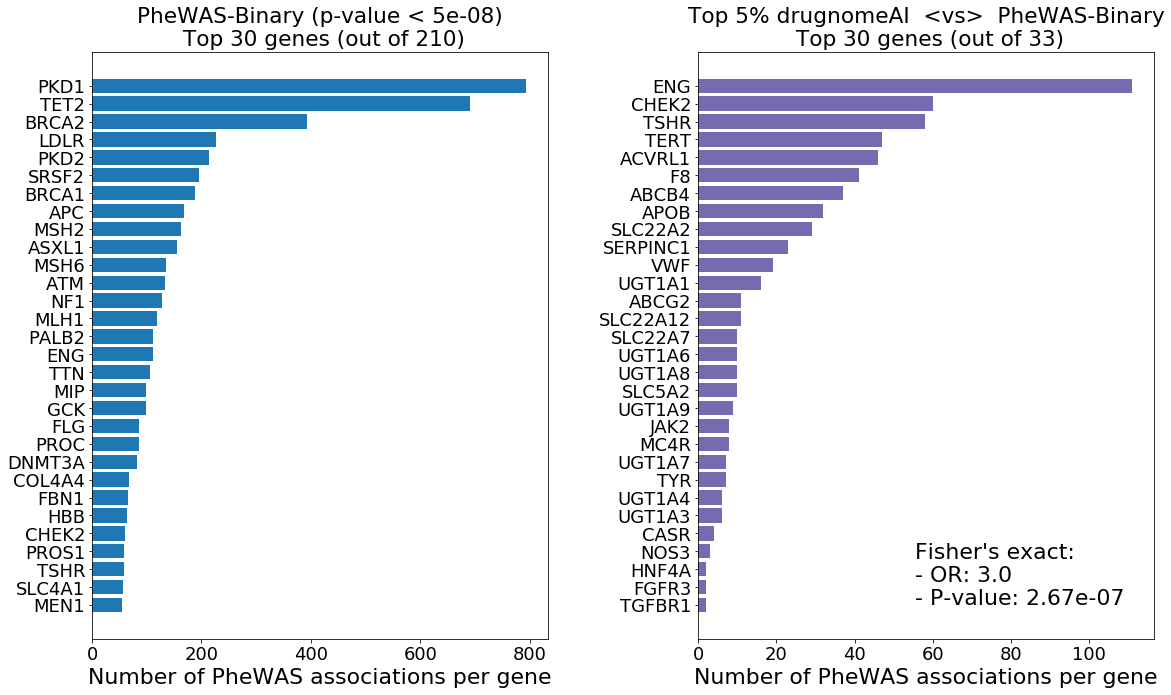

In [168]:
get_drugnomeai_phewas_enrichment(top_drugnome, 'Top 5% drugnomeAI', phewas_bin, 'PheWAS-Binary', genome_wide_p_thres, '#756bb1')

Top 5% drugnomeAI (With Clinical Evidence)
  <vs>  PheWAS-Binary
Total num. of associations: 6729
Unique genes: 210
drugnome_hits: 605
drugnomeAI-supported associations: 487
drugnomeAI-supported - Unique genes: 20 

Fisher's exact:
- OR: 2.98
- P-value: 4.63e-05


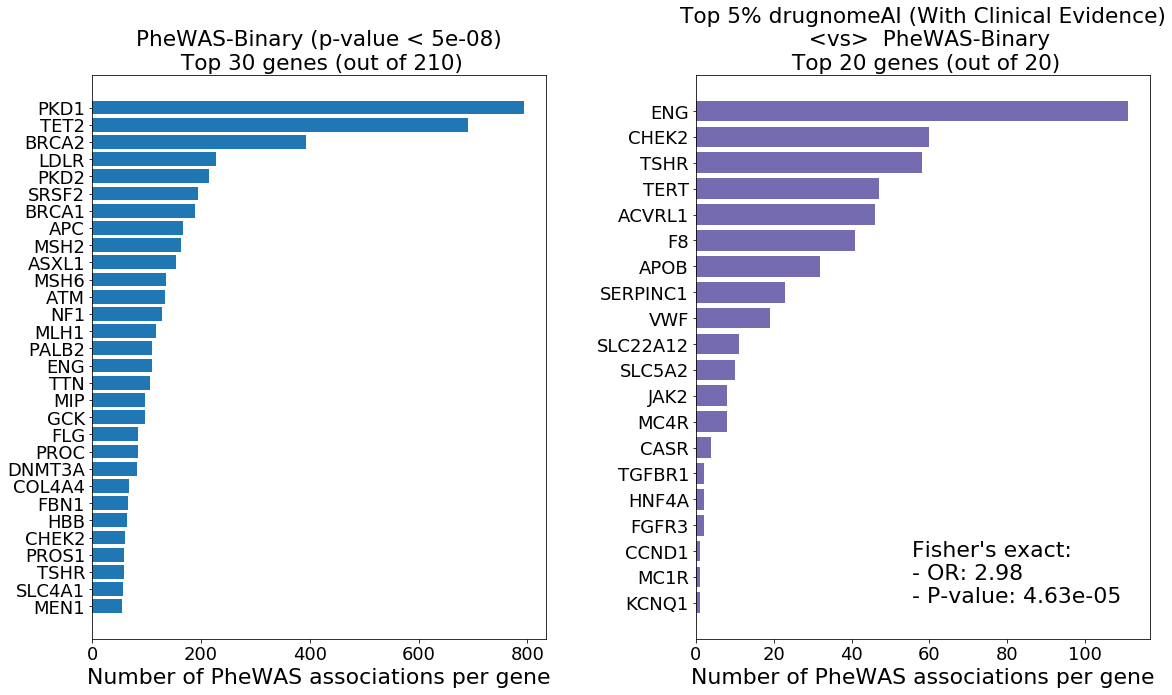

In [169]:
get_drugnomeai_phewas_enrichment(top_drugnome_clin, 'Top 5% drugnomeAI (With Clinical Evidence)\n', phewas_bin, 'PheWAS-Binary', genome_wide_p_thres, '#756bb1')

Top 5% drugnomeAI (No Clinical Evidence)
  <vs>  PheWAS-Binary
Total num. of associations: 6729
Unique genes: 210
drugnome_hits: 387
drugnomeAI-supported associations: 161
drugnomeAI-supported - Unique genes: 13 

Fisher's exact:
- OR: 3.03
- P-value: 7.25e-04


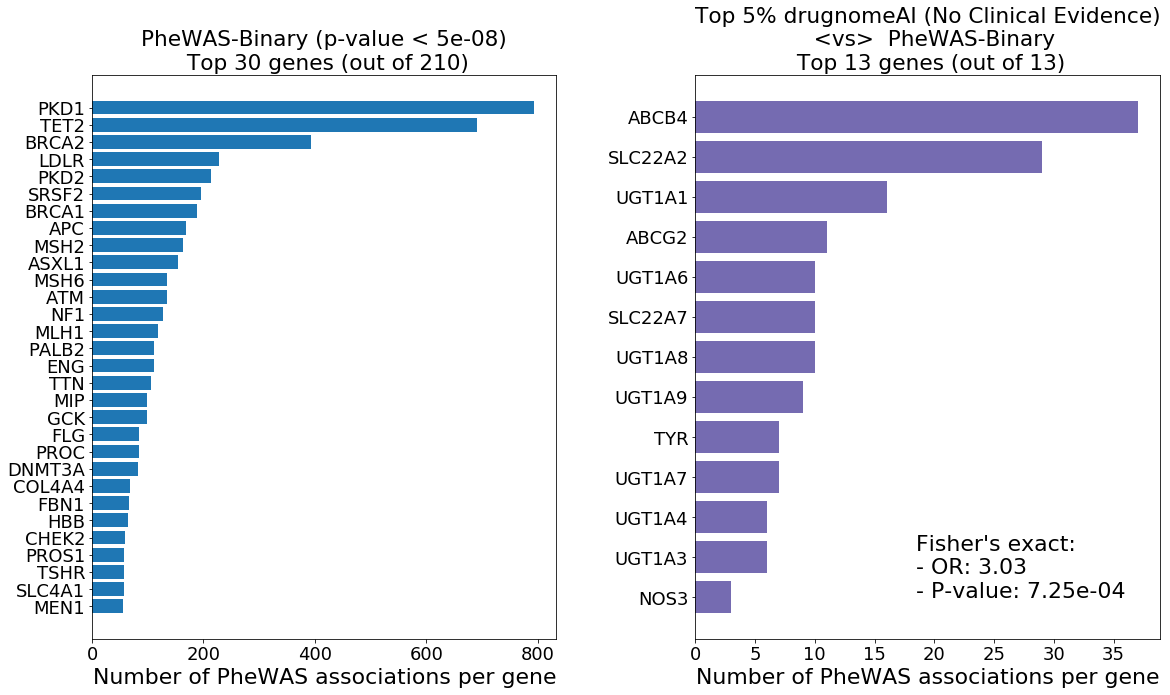

In [170]:
get_drugnomeai_phewas_enrichment(top_drugnome_no_clin, 'Top 5% drugnomeAI (No Clinical Evidence)\n', phewas_bin, 'PheWAS-Binary', genome_wide_p_thres, '#756bb1')

<br>
<br>
<hr>
<br>

## PheWAS-Quantitative vs Top 5% drugnomeAI

Top 5% drugnomeAI  <vs>  PheWAS-Quantitative
Total num. of associations: 6065
Unique genes: 508
drugnome_hits: 992
drugnomeAI-supported associations: 1360
drugnomeAI-supported - Unique genes: 82 

Fisher's exact:
- OR: 3.19
- P-value: 8.19e-17


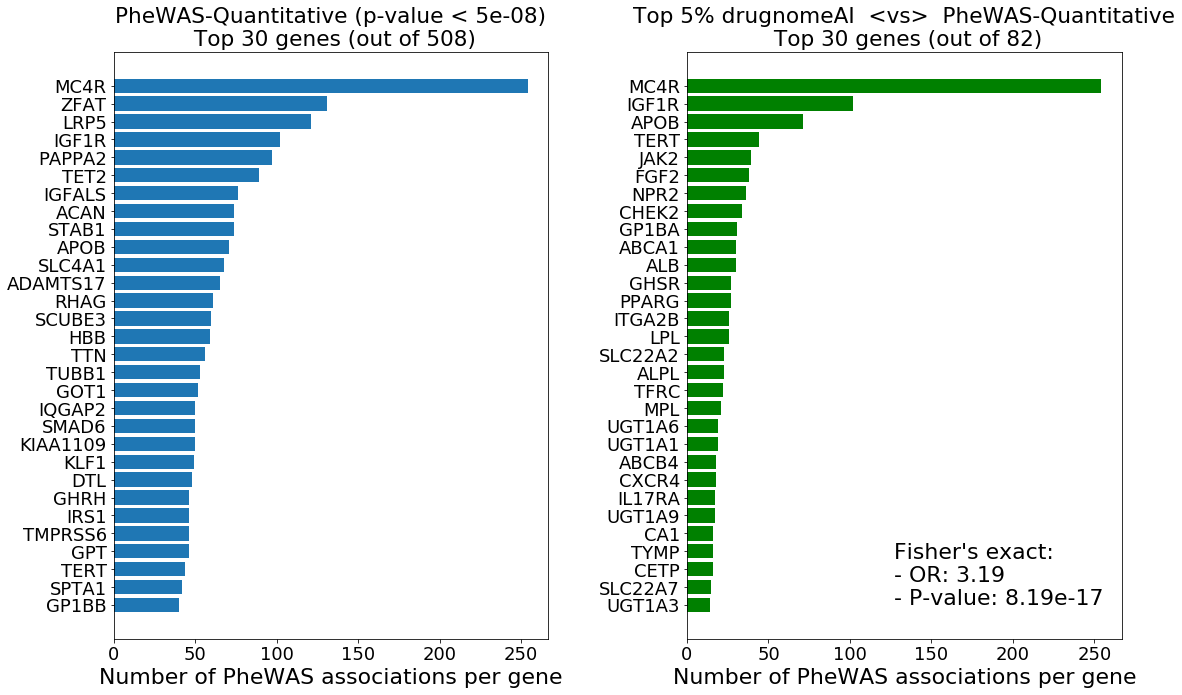

In [171]:
get_drugnomeai_phewas_enrichment(top_drugnome, 'Top 5% drugnomeAI', phewas_quant, 'PheWAS-Quantitative', genome_wide_p_thres, 'green')

Top 5% drugnomeAI (With Clinical Evidence)
  <vs>  PheWAS-Quantitative
Total num. of associations: 6065
Unique genes: 508
drugnome_hits: 605
drugnomeAI-supported associations: 943
drugnomeAI-supported - Unique genes: 47 

Fisher's exact:
- OR: 2.98
- P-value: 9.53e-10


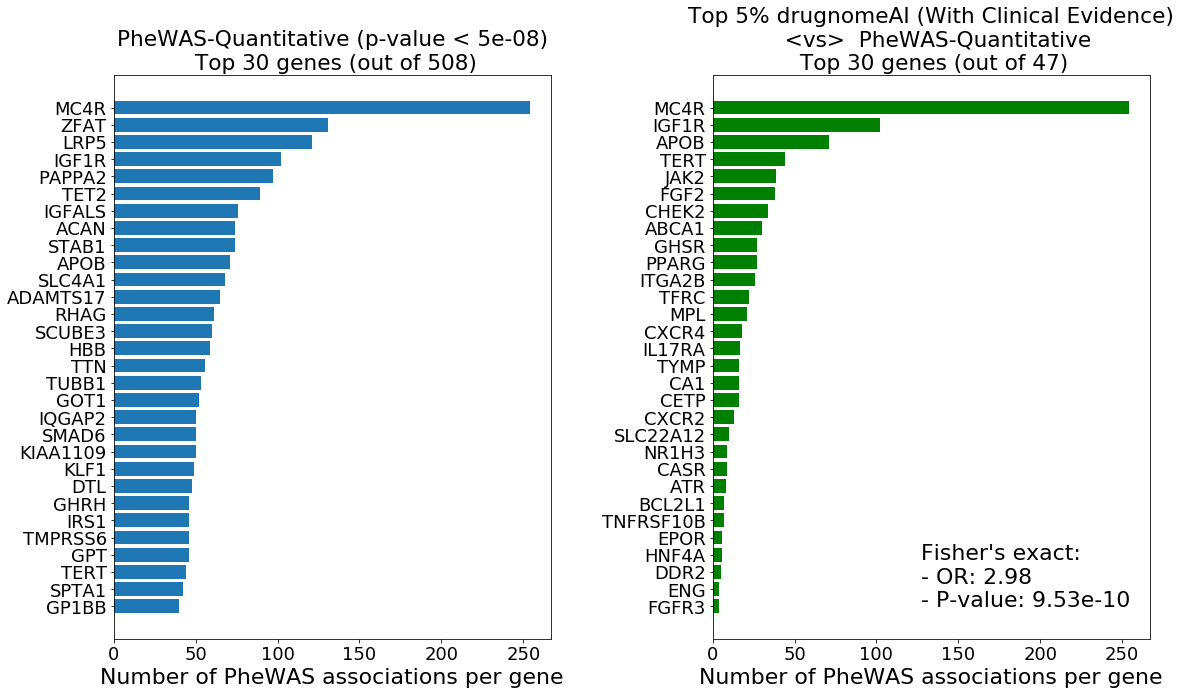

In [172]:
get_drugnomeai_phewas_enrichment(top_drugnome_clin, 'Top 5% drugnomeAI (With Clinical Evidence)\n', phewas_quant, 'PheWAS-Quantitative', genome_wide_p_thres, 'green')

Top 5% drugnomeAI (No Clinical Evidence)
  <vs>  PheWAS-Quantitative
Total num. of associations: 6065
Unique genes: 508
drugnome_hits: 387
drugnomeAI-supported associations: 417
drugnomeAI-supported - Unique genes: 35 

Fisher's exact:
- OR: 3.52
- P-value: 2.34e-09


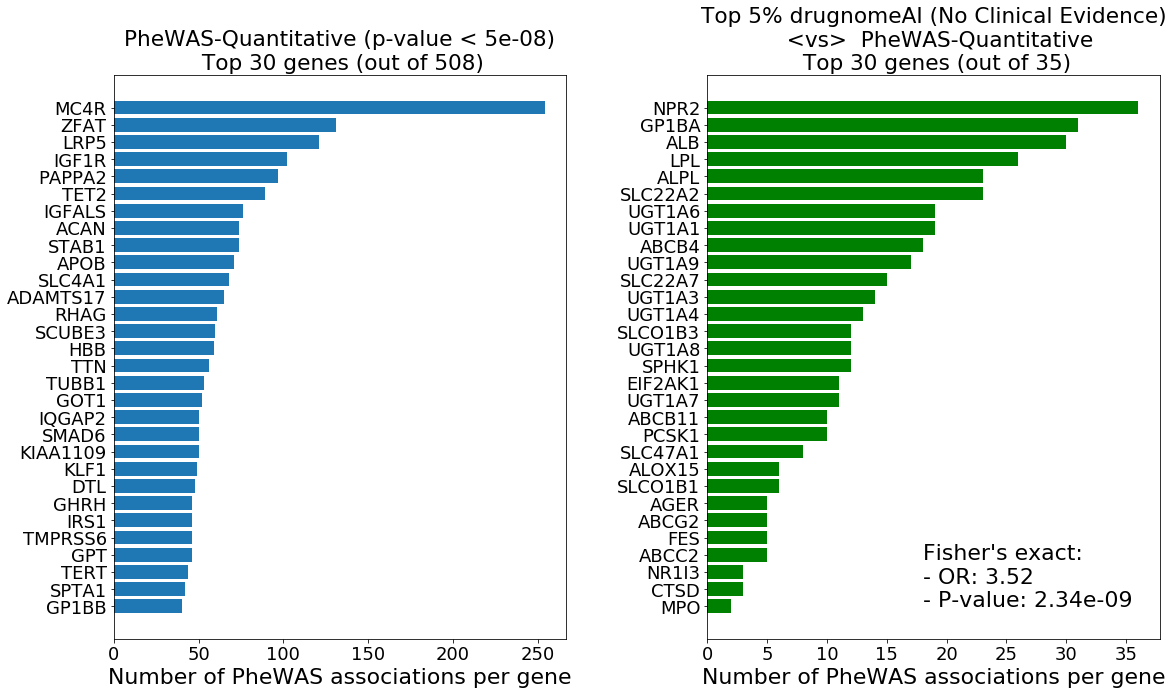

In [173]:
get_drugnomeai_phewas_enrichment(top_drugnome_no_clin, 'Top 5% drugnomeAI (No Clinical Evidence)\n', phewas_quant, 'PheWAS-Quantitative', genome_wide_p_thres, 'green')

<br>
<hr>
<br>

<br>
<br>

# ExWAS

## ExWAS-Binary vs Top 5% drugnomeAI

Top 5% drugnomeAI  <vs>  ExWAS-Binary
Total num. of associations: 64386
Unique genes: 227
drugnome_hits: 992
drugnomeAI-supported associations: 1641
drugnomeAI-supported - Unique genes: 6 

Fisher's exact:
- OR: 0.49
- P-value: 9.64e-02


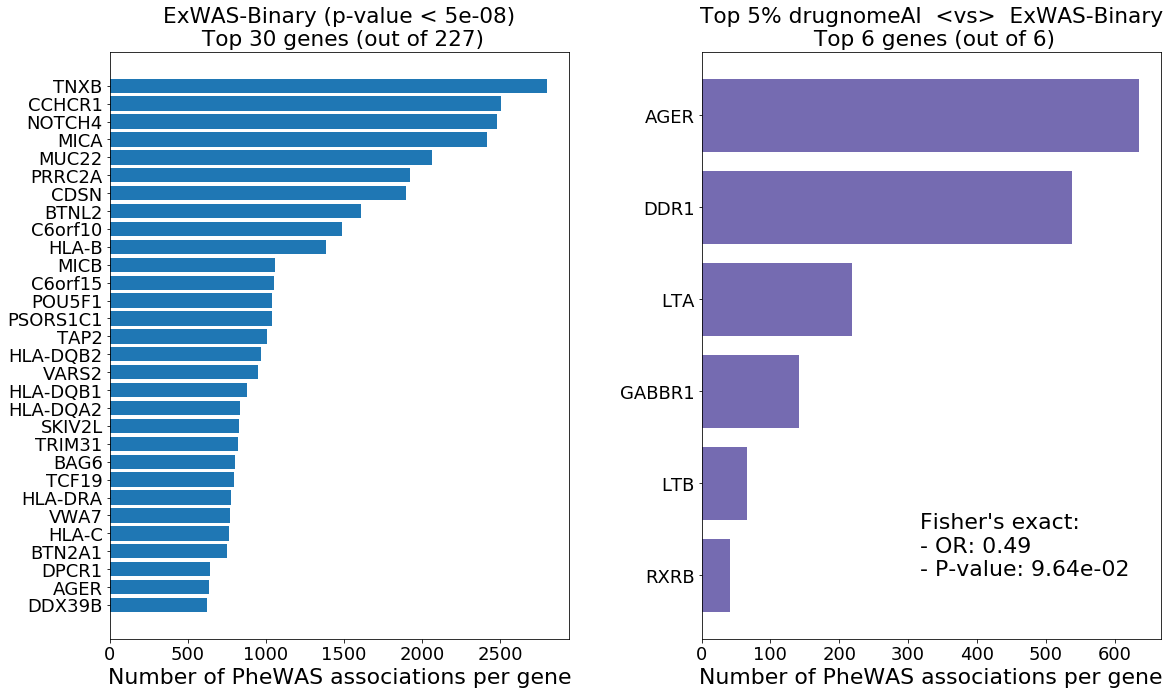

In [174]:
get_drugnomeai_phewas_enrichment(top_drugnome, 'Top 5% drugnomeAI', exwas_bin, 'ExWAS-Binary', genome_wide_p_thres, '#756bb1')

Top 5% drugnomeAI (With Clinical Evidence)
  <vs>  ExWAS-Binary
Total num. of associations: 64386
Unique genes: 227
drugnome_hits: 605
drugnomeAI-supported associations: 468
drugnomeAI-supported - Unique genes: 4 

Fisher's exact:
- OR: 0.54
- P-value: 2.58e-01


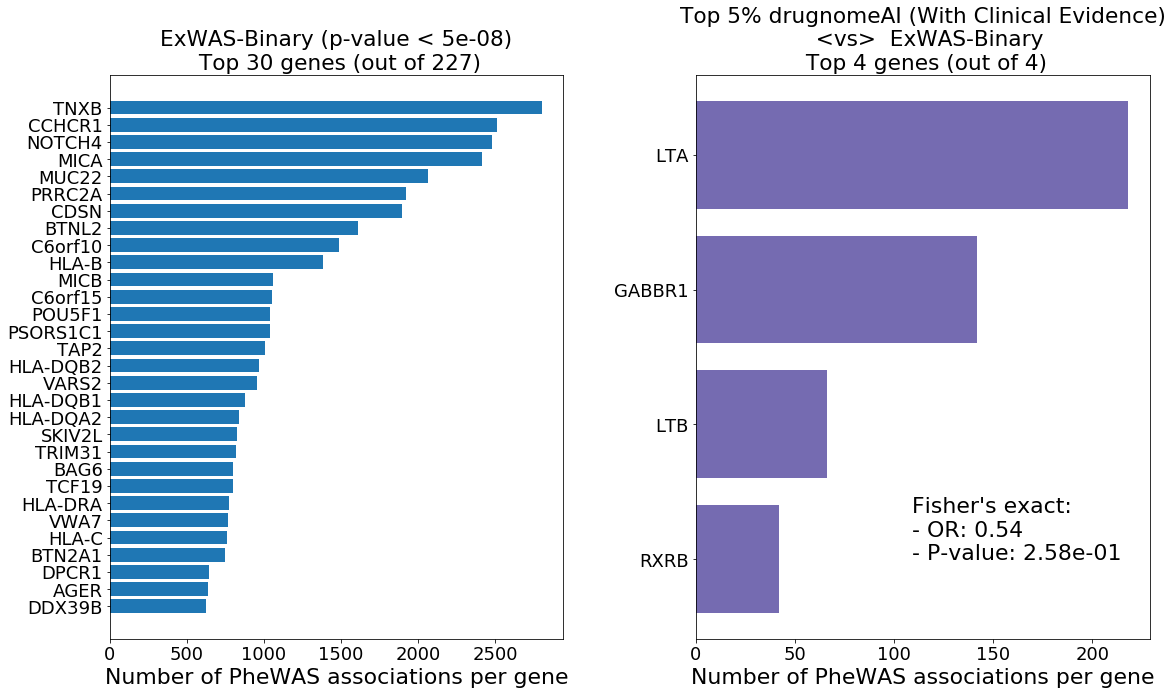

In [175]:
get_drugnomeai_phewas_enrichment(top_drugnome_clin, 'Top 5% drugnomeAI (With Clinical Evidence)\n', exwas_bin, 'ExWAS-Binary', genome_wide_p_thres, '#756bb1')

Top 5% drugnomeAI (No Clinical Evidence)
  <vs>  ExWAS-Binary
Total num. of associations: 64386
Unique genes: 227
drugnome_hits: 387
drugnomeAI-supported associations: 1173
drugnomeAI-supported - Unique genes: 2 

Fisher's exact:
- OR: 0.42
- P-value: 3.40e-01


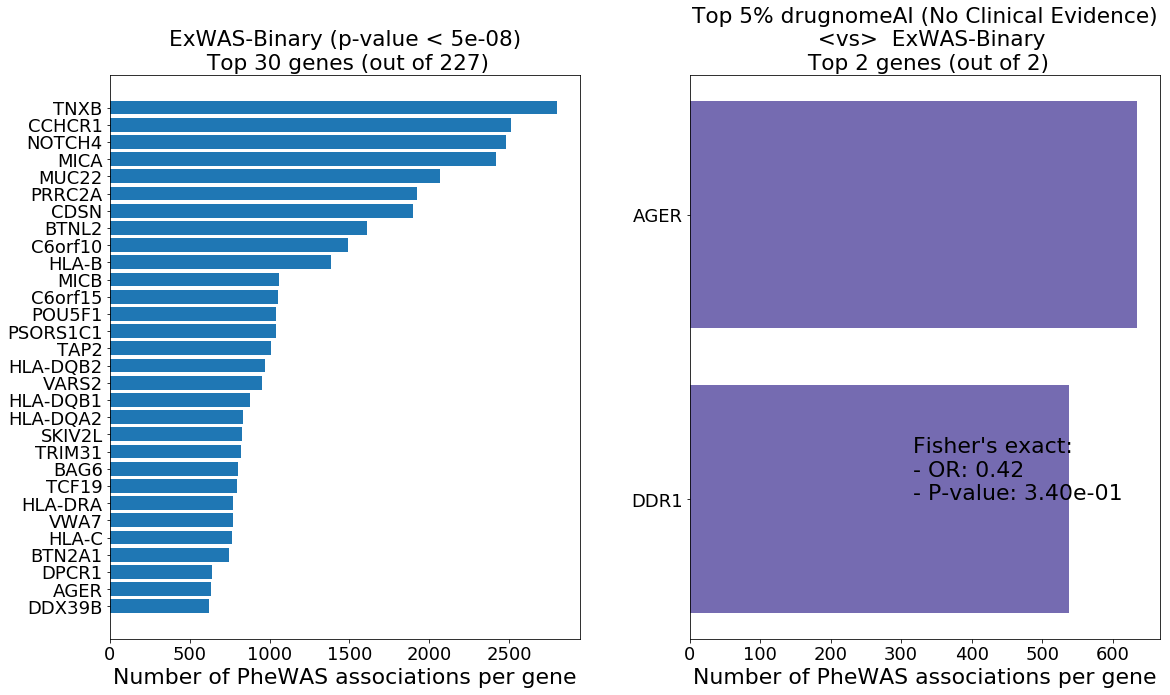

In [176]:
get_drugnomeai_phewas_enrichment(top_drugnome_no_clin, 'Top 5% drugnomeAI (No Clinical Evidence)\n', exwas_bin, 'ExWAS-Binary', genome_wide_p_thres, '#756bb1')

<br>

## ExWAS-Quantitative vs Top 5% drugnomeAI

Top 5% drugnomeAI  <vs>  ExWAS-Quantitative
Total num. of associations: 230660
Unique genes: 7623
drugnome_hits: 992
drugnomeAI-supported associations: 17455
drugnomeAI-supported - Unique genes: 481 

Fisher's exact:
- OR: 1.34
- P-value: 6.73e-06


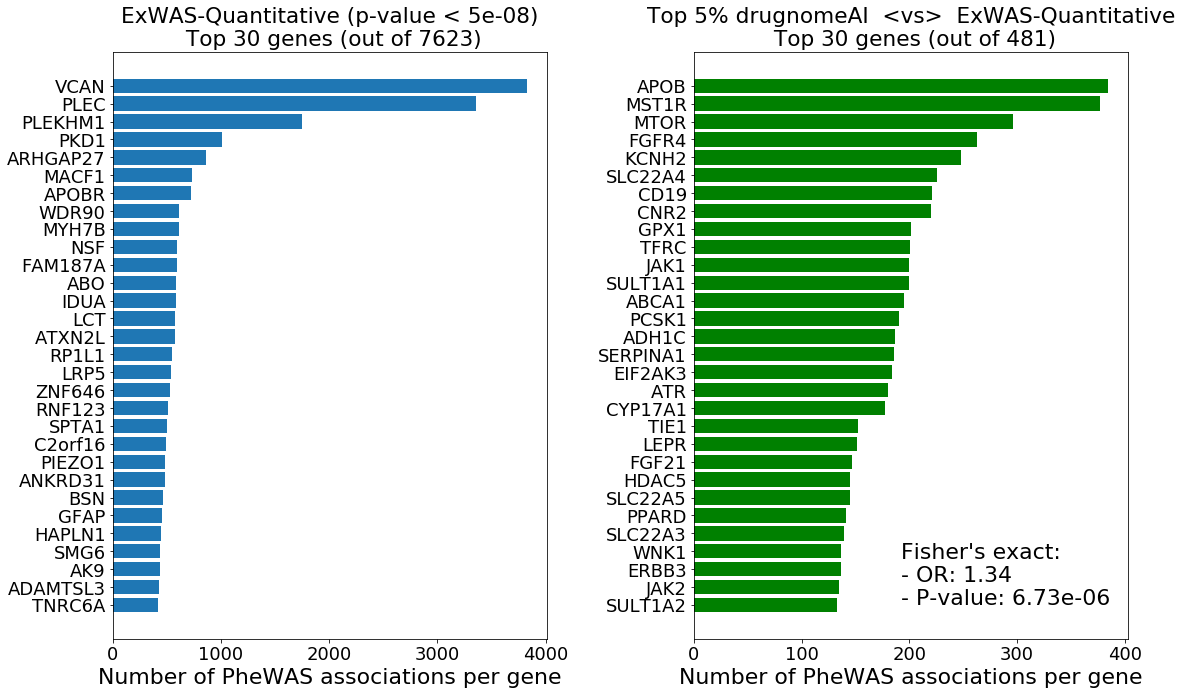

In [177]:
get_drugnomeai_phewas_enrichment(top_drugnome, 'Top 5% drugnomeAI', exwas_quant, 'ExWAS-Quantitative', genome_wide_p_thres, 'green')

Top 5% drugnomeAI (With Clinical Evidence)
  <vs>  ExWAS-Quantitative
Total num. of associations: 230660
Unique genes: 7623
drugnome_hits: 605
drugnomeAI-supported associations: 10409
drugnomeAI-supported - Unique genes: 278 

Fisher's exact:
- OR: 1.21
- P-value: 2.10e-02


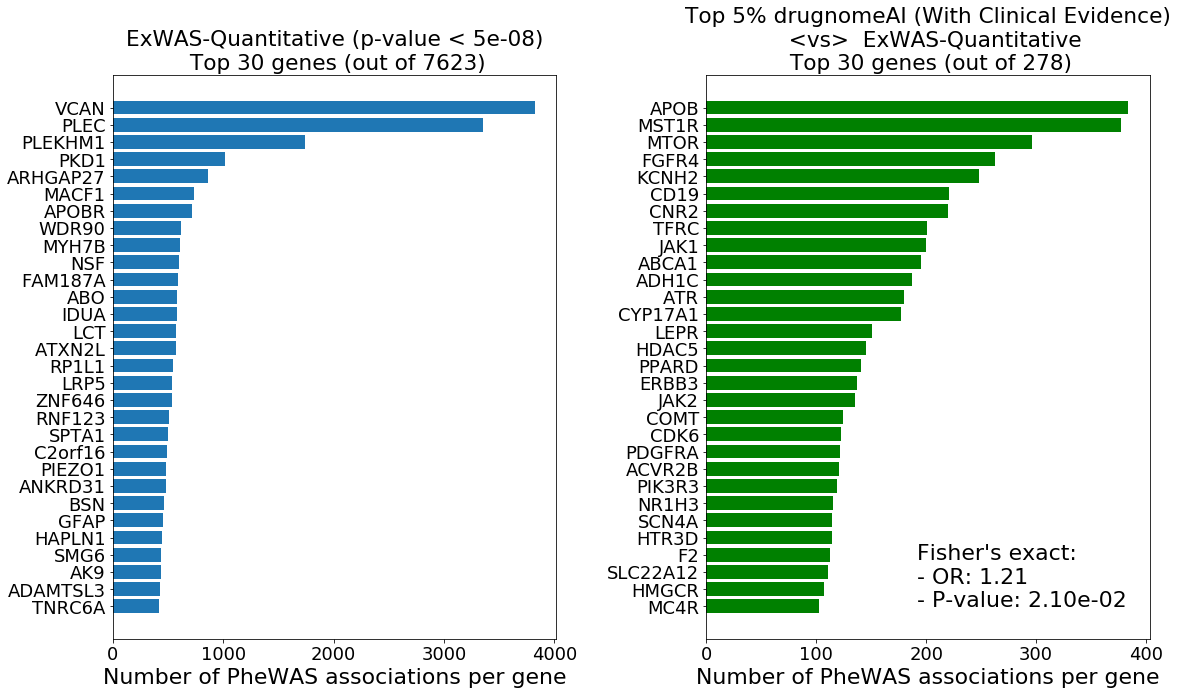

In [178]:
get_drugnomeai_phewas_enrichment(top_drugnome_clin, 'Top 5% drugnomeAI (With Clinical Evidence)\n', exwas_quant, 'ExWAS-Quantitative', genome_wide_p_thres, 'green')

Top 5% drugnomeAI (No Clinical Evidence)
  <vs>  ExWAS-Quantitative
Total num. of associations: 230660
Unique genes: 7623
drugnome_hits: 387
drugnomeAI-supported associations: 7046
drugnomeAI-supported - Unique genes: 203 

Fisher's exact:
- OR: 1.57
- P-value: 1.11e-05


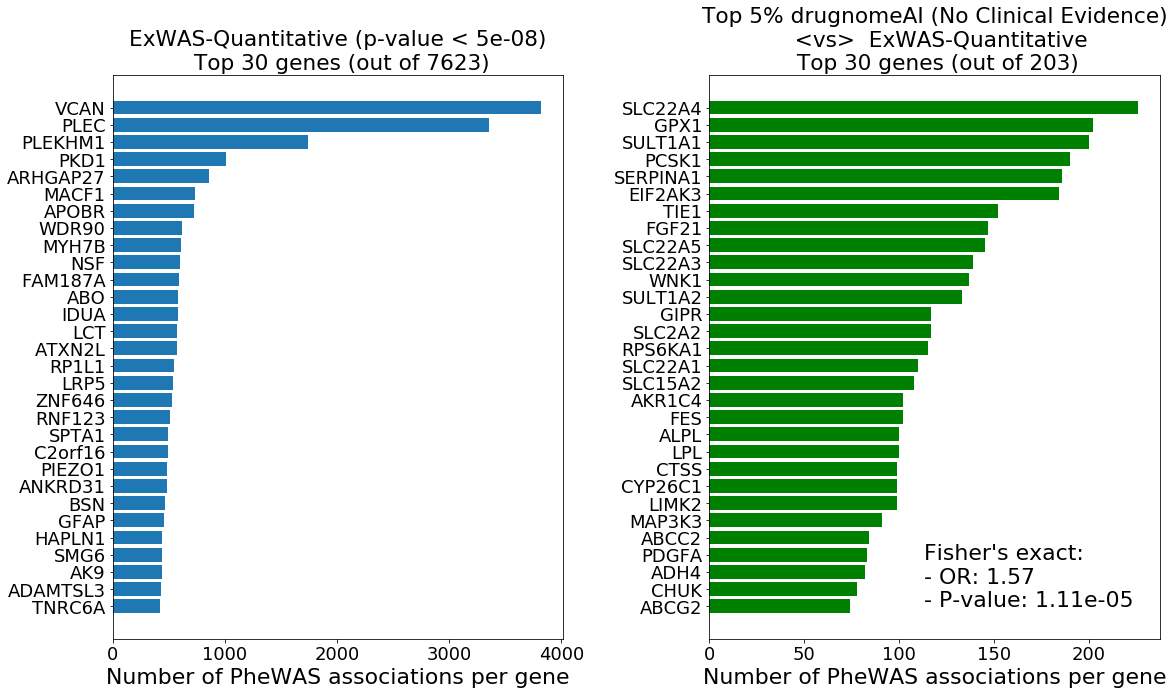

In [179]:
get_drugnomeai_phewas_enrichment(top_drugnome_no_clin, 'Top 5% drugnomeAI (No Clinical Evidence)\n', exwas_quant, 'ExWAS-Quantitative', genome_wide_p_thres, 'green')